##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####  <font color=SlateBlue>Readng Images</font>

In [ ]:
import os
import cv2
import shutil

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as trainTestSplitter
from sklearn.decomposition import PCA

##  <font color=MediumSlateBlue>Classes</font> ##

####  <font color=SlateBlue>Image Loader</font> ####
Methods to load and copy images to various files

In [ ]:
class ImgLoader():
  def __init__(self): pass

  def copyImgToFolder(self, sourcePath, destPath, numBeMoved):
    beMovedImgNames = random.sample(os.listdir(sourcePath), numBeMoved)
    [shutil.copy(os.path.join(sourcePath, imgName), 
                 os.path.join(destPath, imgName)) for imgName in beMovedImgNames]

  def readImgFromFolder(self, filePath, startIndx, numImg):
    imgs = []
    imgFeatures = {'age':[], 'gender':[], 'race':[]}
    
    cnt = 0
    fileNames = os.listdir(filePath) 

    for fileName in fileNames[startIndx:startIndx+numImg]:
      img = cv2.imread(os.path.join(filePath, fileName))
  
      if img is not None:
        imgs.append(img.flatten())
        fileName = fileName.replace('.jpg.chip.jpg', '')
        imgFeatures['age'].append(fileName.split('_')[0])
        imgFeatures['gender'].append(fileName.split('_')[1])
        imgFeatures['race'].append(fileName.split('_')[2])

      cnt=cnt+1
      if cnt>numImg: break

    return imgs, imgFeatures

  def showImgsInFolder(self, filePath, numImgShow):
    imgs, imgFeatures = self.readImgFromFolder(filePath, numImgShow)

    for imgIndx in range(numImgShow):
      plt.imshow(imgs[imgIndx].reshape(200, 200, 3))
      plt.title('age: ' + str(imgFeatures['age'][imgIndx]) + 
                '\n gender: ' + str(imgFeatures['gender'][imgIndx]) + 
                '\n race: ' + str(imgFeatures['race'][imgIndx]))
      plt.xticks(())
      plt.yticks(())
      plt.show()

  def showSelectedImg(self, imgs, imgFeatures, imgIndx):
    plt.imshow(imgs[imgIndx].reshape(200, 200, 3))
    plt.title('age: ' + str(imgFeatures['age'][imgIndx]) + 
              '\n gender: ' + str(imgFeatures['gender'][imgIndx]) + 
              '\n race: ' + str(imgFeatures['race'][imgIndx]))
    plt.xticks(())
    plt.yticks(())
    plt.show()


####  <font color=SlateBlue>Preprocessng</font> ####
Methods to preprocess data and making it ready as the input of neural network

In [ ]:
class Preprocessing():
  def __init__(self): pass

  def splitter(self, data, dataLabels, size=0.2):
    return trainTestSplitter(data, dataLabels, test_size=size, random_state=42)

  def trainNormalizer(self, data, method='normalize'):
    if method == 'Standard Scaler':
      scaler = preprocessing.StandardScaler()
    elif method == 'Min Max Scaler':
      scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
    elif method == 'normalize':
      scaler = preprocessing.Normalizer()

    scaler.fit(data)
    self.scaler = scaler

    return scaler.transform(data)

  def employNormalizer(self, data): return (self.scaler).transform(data)

  def trainPCA(self, data, numComp=128, whitenState=False):
    _pca = PCA(n_components=numComp, whiten=whitenState, random_state=42)

    _pca.fit(data)
    self.pca = _pca

    return _pca.transform(data)

  def employPCA(self, data): return (self.pca).transform(data)

####  <font color=SlateBlue>Batches of Data</font> ####
Methods to read data in a batch format

In [ ]:
class BatchDataCreator():
  def __init__(self, _data, _dataLabels, _batchSize):
    self.data = _data
    self.dataLabels = _dataLabels
    self.batchSize = _batchSize
  def __iter__(self):
    for indx in range(0, len(self.data), self.batchSize):
      yield (np.matrix(self.data[indx:indx+self.batchSize]), 
             np.matrix(self.dataLabels[indx:indx+self.batchSize]))

##  <font color=MediumSlateBlue>Loading Images</font> ##

Copy samples to a specific file and read them.

In [ ]:
sourcePath = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/1/Dataset/UTKFace' #direction of main dataset
destPath = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/1/Dataset/UTKFace_Samples' #direction where 3000 images need to be copied 

In [ ]:
myImgLoader = ImgLoader()

In [ ]:
myImgLoader.copyImgToFolder(sourcePath, destPath, 3000)

In [ ]:
imgs, imgFeatures = myImgLoader.readImgFromFolder(destPath, 0, 3000)

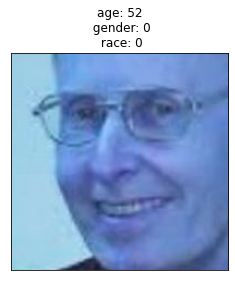

In [ ]:
myImgLoader.showSelectedImg(imgs, imgFeatures, 12)

##  <font color=MediumSlateBlue>Preprocess and save data</font>

In [ ]:
preprocess = Preprocessing()

In [ ]:
imgs = preprocess.trainNormalizer(imgs, method='normalize')

In [ ]:
imgs.shape

(3000, 120000)

In [ ]:
imgs = preprocess.trainPCA(imgs, 128)

In [ ]:
imgs.shape

(3000, 128)

In [ ]:
beStoredData = np.zeros((1000,131))

clmName = []
for i in range(1,129):
  clmName.append('pixel'+str(i))
clmName.append('age')
clmName.append('gender')
clmName.append('race')

for i in range(0,20000, 1000):
  imgs, imgFeatures = myImgLoader.readImgFromFolder(sourcePath, i, 1000)

  imgs = preprocess.employNormalizer(imgs)
  imgs = preprocess.employPCA(imgs)

  beStoredData[:,0:128] = imgs
  beStoredData[:,128] = np.array(imgFeatures['age'])
  beStoredData[:,129] = np.array(imgFeatures['gender'])
  beStoredData[:,130] = np.array(imgFeatures['race'])
  

  df = pd.DataFrame(beStoredData, columns=clmName)
  df.to_csv(r'/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/1/Dataset/Reduced_UTKFace/dataset'+str(int(i/1000))+'.csv', index = False) #direction where csv files are stored